# 3.10

In [5]:
from torch import nn
import torch
import numpy as np

In [2]:
paris_coords = np.array([
    [48.8575, 2.3514], #Center of Paris
    [48.8584, 2.2945], # Eiffel Tower
    [48.8530, 2.3499], #Notre Dame
    [48.8606,  2.3376], #Louvre
    [48.8606, 2.3522]  #Centre Pompidou
])

madrid_coords = np.array([
    [40.4167, -3.7033],   # Center of Madrid
    [40.4153, -3.6835],   # Retiro Park 
    [40.4180, -3.7143],   # Royal Palace 
    [40.4138, -3.6921],   # Prado Museum 
    [40.4169, -3.7033]   # Puerta del Sol 
])

In [17]:
X = np.vstack([paris_coords, madrid_coords])
y = np.array([0, 0, 0, 0, 0,  #  Madrid labels (0)
              1, 1, 1, 1, 1,  #  Paris labels (1)
])

shuffle_idx = np.random.permutation(len(y))
X = X[shuffle_idx, 1:2]
y = y[shuffle_idx]

In [18]:
class MyNetwork(nn.Module):
    def __init__(self, input: int, output: int):
        super(MyNetwork, self).__init__()
        self.l1 = nn.Linear(input, output)
    
    def forward(self, x):

        return self.l1(x)


In [19]:
num_epoch = 100
lr = 0.005
model = MyNetwork(1, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

for i in range(num_epoch):

    optimizer.zero_grad()
    out = model(torch.tensor(X[i%len(y)]).float())
    loss = criterion(out, torch.tensor(y[i%len(y)]))

    loss.backward()
    optimizer.step()

    if (i + 1) % 10 == 0:
        with torch.no_grad():
            logits=model(torch.tensor(X, dtype=torch.float)) 
            accuracy=(torch.argmax(logits, dim=1)==torch.tensor(y)).sum().item()/len(y)
        print(f"Step {i+1}/{num_epoch}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

Step 10/100, Loss: 3.5408, Accuracy: 0.0000
Step 20/100, Loss: 2.8838, Accuracy: 0.0000
Step 30/100, Loss: 2.2801, Accuracy: 0.0000
Step 40/100, Loss: 1.7659, Accuracy: 0.0000
Step 50/100, Loss: 1.3670, Accuracy: 0.0000
Step 60/100, Loss: 1.0771, Accuracy: 0.5000
Step 70/100, Loss: 0.8698, Accuracy: 0.5000
Step 80/100, Loss: 0.7195, Accuracy: 0.5000
Step 90/100, Loss: 0.6078, Accuracy: 1.0000
Step 100/100, Loss: 0.5226, Accuracy: 1.0000


Single Nueron GD

In [6]:
X = np.array([1, 2, 3, 4])
y = np.array([3,5,7,9])

shuffle_idx = np.random.permutation(len(y))

X = X[shuffle_idx]
y = y[shuffle_idx]

In [22]:
print(X)
print(y)

[4 1 2 3]
[9 3 5 7]


In [14]:
# Loss functions - switch between L1 and L2

def loss_l1(model_out, gt):
    return np.abs(model_out - gt)

def loss_l2(model_out, gt):
    return (model_out - gt)**2

def m_grad_l1(model_out, input, gt):
    return -np.sign(model_out - gt) * input

def m_grad_l2(model_out, input, gt):
    return -2 * (model_out - gt) * input

def b_grad_l1(model_out, gt):
    return -np.sign(model_out - gt)

def b_grad_l2(model_out, gt):
    return -2 * (model_out - gt)

class Model:
    def __init__(self):
        self.m = 1
        self.b = 0
    
    def forward(self, input):
        return self.m*input + self.b

    def update(self, m_update, b_update):
        self.m += m_update
        self.b += b_update
    
    def get_model(self):
        print(f"Slope: {self.m} Intercept {self.b}")


def train(num_steps, lr, loss_type='l2'):
    """
    Train the model with specified loss type.
    
    Args:
        num_steps: Number of training steps
        lr: Learning rate
        loss_type: 'l1' for L1 loss, 'l2' for L2 (squared) loss
    """
    # Select loss and gradient functions based on loss_type
    if loss_type.lower() == 'l1':
        loss_fn = loss_l1
        m_grad_fn = m_grad_l1
        b_grad_fn = b_grad_l1
    elif loss_type.lower() == 'l2':
        loss_fn = loss_l2
        m_grad_fn = m_grad_l2
        b_grad_fn = b_grad_l2
    else:
        raise ValueError(f"loss_type must be 'l1' or 'l2', got '{loss_type}'")
    
    model = Model()

    for i in range(num_steps):
        index = i % len(y)
        input = X[index]
        gt = y[index]

        model_out = model.forward(input)
        loss_val = loss_fn(model_out, gt)

        if i % (num_steps/10) == 0:
            print(f"Epoch {i} Loss Val {loss_val:.6f}")

        m_update = m_grad_fn(model_out, input, gt)
        b_update = b_grad_fn(model_out, gt)

        model.update(m_update*lr, b_update*lr)
    
    model.get_model()
    return model




## Why L1 Loss Converges Slower

**Key Differences:**

1. **Gradient Magnitude:**
   - **L2**: Gradient ∝ error magnitude → adaptive step size
   - **L1**: Gradient magnitude is constant → fixed step size

2. **Near Optimum:**
   - **L2**: Small errors → small gradients → fine-tuning
   - **L1**: Constant gradient → can overshoot and oscillate

3. **Smoothness:**
   - **L2**: Smooth everywhere (better for gradient descent)
   - **L1**: Non-differentiable at zero (subgradient discontinuity)


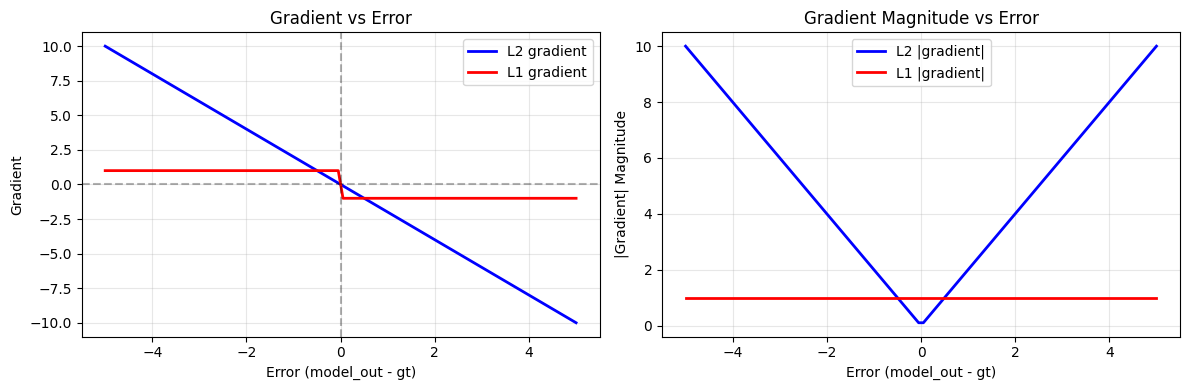

Key Observation:
- L2 gradient magnitude decreases as error approaches zero → adaptive step size
- L1 gradient magnitude stays constant → fixed step size (can cause oscillations)


In [10]:
# Visualize gradient behavior for L1 vs L2

import matplotlib.pyplot as plt

# Simulate error values
errors = np.linspace(-5, 5, 100)

# L2 gradient (proportional to error)
l2_grad = -2 * errors

# L1 gradient (constant magnitude, only sign changes)
l1_grad = -np.sign(errors)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(errors, l2_grad, 'b-', linewidth=2, label='L2 gradient')
plt.plot(errors, l1_grad, 'r-', linewidth=2, label='L1 gradient')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Error (model_out - gt)')
plt.ylabel('Gradient')
plt.title('Gradient vs Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(errors, np.abs(l2_grad), 'b-', linewidth=2, label='L2 |gradient|')
plt.plot(errors, np.abs(l1_grad), 'r-', linewidth=2, label='L1 |gradient|')
plt.xlabel('Error (model_out - gt)')
plt.ylabel('|Gradient| Magnitude')
plt.title('Gradient Magnitude vs Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observation:")
print("- L2 gradient magnitude decreases as error approaches zero → adaptive step size")
print("- L1 gradient magnitude stays constant → fixed step size (can cause oscillations)")


In [15]:
num_steps = 5000
lr = 0.05

# Train with L2 (squared) loss (default)
print("Training with L2 (squared) loss:")
train(num_steps, lr, loss_type='l2')

print("\n" + "="*50 + "\n")

# Train with L1 loss
print("Training with L1 (absolute) loss:")
train(num_steps, lr, loss_type='l1')

Training with L2 (squared) loss:
Epoch 0 Loss Val 9.000000
Epoch 500 Loss Val 0.000000
Epoch 1000 Loss Val 0.000000
Epoch 1500 Loss Val 0.000000
Epoch 2000 Loss Val 0.000000
Epoch 2500 Loss Val 0.000000
Epoch 3000 Loss Val 0.000000
Epoch 3500 Loss Val 0.000000
Epoch 4000 Loss Val 0.000000
Epoch 4500 Loss Val 0.000000
Slope: 2.0000000000000004 Intercept 0.9999999999999988


Training with L1 (absolute) loss:
Epoch 0 Loss Val 3.000000
Epoch 500 Loss Val 0.200000
Epoch 1000 Loss Val 0.200000
Epoch 1500 Loss Val 0.200000
Epoch 2000 Loss Val 0.200000
Epoch 2500 Loss Val 0.200000
Epoch 3000 Loss Val 0.200000
Epoch 3500 Loss Val 0.200000
Epoch 4000 Loss Val 0.200000
Epoch 4500 Loss Val 0.200000
Slope: 2.3 Intercept 0.6
